In [1]:
# Connect to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Import**

In [ ]:
# Import Library
import os
import sys
import shutil
from multiprocessing import Pool

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import soundfile as sf
from scipy.signal import lfilter
from copy import deepcopy
from tqdm import tqdm

import tensorflow as tf
import tensorflow_hub as hub

sys.path.append('/content/drive/My Drive/[3] Model ML TBCare/')
import speechproc

# **Metadata Exploration**

## **Load Metadata**

In [ ]:
df = pd.read_csv("/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia/Metadata and Codebook/GHAI_Final_Data_2023.csv")
df

,sex,consent_obtained,barcode,coughdur,cough_productive,haemoptysis,chestpain,shortbreath,fever,ngtsweats,...,tb_class_index,tb_predictions,tb_predictions1,age,meters_height,bmi,smear_all,type_tb,ground_truth_tb,facility_code
0,m,1,01-399-0258,1-2wks,yes,no,yes,yes,no,yes,...,1,0.654549,0.345451,31,1.62,24.0,neg,No TBdx,neg,Kan
1,m,1,01-399-1081,<1wk,yes,no,yes,yes,yes,yes,...,1,0.438112,0.561888,58,1.64,14.0,neg,No TBdx,neg,Kan
2,m,1,02-399-0856,<1wk,yes,yes,yes,yes,yes,yes,...,1,0.414009,0.585991,24,1.83,16.0,neg,No TBdx,neg,Cha
3,f,1,03-399-0290,1-2wks,yes,no,yes,no,no,yes,...,1,0.607053,0.392947,25,1.70,21.0,neg,No TBdx,neg,Chai
4,m,1,01-399-0744,<1wk,yes,yes,yes,yes,yes,yes,...,1,0.401624,0.598376,30,1.70,20.0,neg,No TBdx,neg,Kan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,f,1,02-399-0239,no cough,NaN,NaN,no,no,no,no,...,1,0.846709,0.153291,24,1.58,26.0,neg,No TBdx,neg,Cha
1824,f,1,02-399-0214,<1wk,yes,no,yes,yes,yes,no,...,1,0.842927,0.157073,21,1.56,22.0,neg,No TBdx,neg,Cha
1825,m,1,01-399-0973,<1wk,yes,no,yes,no,yes,yes,...,1,0.783166,0.216834,47,1.70,21.0,neg,No TBdx,neg,Kan
1826,m,1,02-399-0711,>4weeks,yes,yes,yes,yes,yes,no,...,1,0.764668,0.235332,23,1.65,20.0,neg,No TBdx,neg,Cha


In [ ]:
count_values = df["ground_truth_tb"].value_counts()
print(count_values)

ground_truth_tb
neg    1623
pos     205
Name: count, dtype: int64


# **Pre-Processing**

## **0_Raw**

In [ ]:
# === Konfigurasi Path ===
BASE_PATH = "/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia"
METADATA_PATH = os.path.join(BASE_PATH, "Metadata and Codebook/GHAI_Final_Data_2023.csv")

INPUT_FOLDERS = [
    "Chainda South Phone A", "Chainda South Phone B", "Chainda South Phone C",
    "Chawama Phone A", "Chawama Phone B", "Chawama Phone C",
    "Kanyama Phone A", "Kanyama Phone B", "Kanyama Phone C",
    "Audio-Recorder-Chainda-South", "Audio-Recorder-Chawama", "Audio-Recorder-Kanyama"
]

OUTPUT_ROOT = os.path.join(BASE_PATH, "0_Raw")
os.makedirs(os.path.join(OUTPUT_ROOT, "pos"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_ROOT, "neg"), exist_ok=True)

# === Muat Metadata CSV ===
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df = metadata_df[['sex', 'barcode', 'anon_id', 'ground_truth_tb']]
barcode_to_label = dict(zip(metadata_df['barcode'], metadata_df['ground_truth_tb']))

# === Helper ===
def parse_facility_tool(folder_name):
    if folder_name.startswith("Audio-Recorder-"):
        parts = folder_name.split("-")
        facility = parts[-1]
        if facility == "South":
            facility = "Chainda South"
        return facility, "Audio Recorder"
    else:
        parts = folder_name.split(" Phone ")
        facility = parts[0].strip()
        tool = "Phone " + parts[1].strip()
        return facility, tool

# === Worker ===
def process_file(args):
    folder_in, fname = args
    if not fname.lower().endswith(".wav"):
        return None

    barcode = os.path.splitext(fname)[0]
    tb_label = barcode_to_label.get(barcode, None)
    if tb_label is None:
        return None

    label = "pos" if str(tb_label).lower() in ["positive", "1", "pos"] else "neg"
    src_path = os.path.join(BASE_PATH, folder_in, fname)

    # --- Parse facility & tool ---
    facility, tool = parse_facility_tool(folder_in)

    # --- Mapping tool ke suffix ---
    if "Phone A" in tool:
        suffix = "A"
    elif "Phone B" in tool:
        suffix = "B"
    elif "Phone C" in tool:
        suffix = "C"
    elif "Audio Recorder" in tool:
        suffix = "R"
    else:
        suffix = "X"  # fallback

    # --- Rename file output ---
    out_fname = f"{barcode}-{suffix}.wav"
    dst_path = os.path.join(OUTPUT_ROOT, label, out_fname)

    try:
        shutil.copy2(src_path, dst_path)
        return {
            "barcode": barcode,
            "file_name": out_fname,
            "label": label,
            "sex": metadata_df.loc[metadata_df['barcode'] == barcode, 'sex'].values[0],
            "anon_id": metadata_df.loc[metadata_df['barcode'] == barcode, 'anon_id'].values[0],
            "ground_truth_tb": tb_label,
            "facility_code": facility,
            "tool": tool
        }
    except Exception as e:
        print(f"❌ Error copy {src_path}: {e}")
        return None

# === Main ===
def main():
    # Hitung total file dulu
    all_tasks = []
    folder_to_tasks = {}
    for folder_in in INPUT_FOLDERS:
        full_folder_in_path = os.path.join(BASE_PATH, folder_in)
        if not os.path.exists(full_folder_in_path):
            print(f"⚠️ Skip folder {full_folder_in_path}")
            continue

        tasks = [(folder_in, fname) for fname in os.listdir(full_folder_in_path)]
        if tasks:
            folder_to_tasks[folder_in] = tasks
            all_tasks.extend(tasks)

    print(f"🔍 Total file ditemukan: {len(all_tasks)}\n")

    NUM_PROCESSES = 2
    results = []
    with Pool(processes=NUM_PROCESSES) as pool:
        for folder_in, tasks in folder_to_tasks.items():
            print(f"📂 Proses folder: {folder_in} ({len(tasks)} file)")
            for r in tqdm(pool.imap_unordered(process_file, tasks),
                          total=len(tasks), desc=folder_in, leave=True):
                if r is not None:
                    results.append(r)

    # simpan metadata
    out_meta = pd.DataFrame(results)
    out_meta.to_csv(os.path.join(OUTPUT_ROOT, "metadata_raw.csv"), index=False)
    print(f"\n✅ Selesai! Metadata tersimpan di {OUTPUT_ROOT}/metadata_raw.csv")

if __name__ == "__main__":
    main()

## **1_Segmentasi**

In [ ]:
# === Konfigurasi Path ===
BASE_PATH = "/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia"
RAW_PATH = os.path.join(BASE_PATH, "0_Raw")
META_RAW_PATH = os.path.join(RAW_PATH, "metadata_raw.csv")
SEG_PATH = os.path.join(BASE_PATH, "1_Segmented")
os.makedirs(os.path.join(SEG_PATH, "pos"), exist_ok=True)
os.makedirs(os.path.join(SEG_PATH, "neg"), exist_ok=True)

META_OUT_PATH = os.path.join(SEG_PATH, "metadata_segmented.csv")

# === Muat Metadata Raw ===
meta_raw = pd.read_csv(META_RAW_PATH)

# === Fungsi VAD ===
def getVad(data, fs):
    winlen, ovrlen, pre_coef, nfilter, nftt = 0.025, 0.01, 0.97, 20, 512
    ftThres = 0.5
    vadThres = 0.4
    opts = 1

    ft, flen, fsh10, nfr10 = speechproc.sflux(data, fs, winlen, ovrlen, nftt)
    pv01 = np.zeros(nfr10)
    pv01[np.less_equal(ft, ftThres)] = 1
    pitch = deepcopy(ft)
    pvblk = speechproc.pitchblockdetect(pv01, pitch, nfr10, opts)

    ENERGYFLOOR = np.exp(-50)
    b = np.array([0.9770, -0.9770])
    a = np.array([1.0000, -0.9540])
    fdata = lfilter(b, a, data, axis=0)

    noise_samp, _, n_noise_samp = speechproc.snre_highenergy(
        fdata, nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk
    )
    for j in range(n_noise_samp):
        fdata[round(noise_samp[j, 0]): round(noise_samp[j, 1]) + 1] = 0

    vad_seg = speechproc.snre_vad(
        fdata, nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk, vadThres
    )
    return vad_seg

# === Segmentasi ===
def segment_audio(file_path):
    X, sample_rate = librosa.load(file_path, sr=22050, mono=True)
    fvad = getVad(X, sample_rate)

    list_X, temp = [], []
    for i in range(1, len(fvad)):
        if fvad[i - 1] == 1:
            len_sector = math.floor(len(X) / len(fvad))
            start = (i - 1) * len_sector
            for j in range(start, start + len_sector):
                if j < len(X):
                    temp.append(X[j])
        if fvad[i - 1] == 1 and fvad[i] == 0:
            list_X.append(temp)
            temp = []
    return np.array(list_X, dtype=object), sample_rate

# === Worker ===
def process_file(args):
    file_path, barcode, label, row_dict = args
    new_rows = []
    try:
        segments, sr = segment_audio(file_path)
        
        # Ekstrak informasi tool dari nama file
        filename = os.path.basename(file_path)
        tool_code = filename.rsplit('-', 1)[-1][0] # Ambil karakter terakhir sebelum ekstensi
        
        tool_mapping = {
            'A': 'Phone A',
            'B': 'Phone B',
            'C': 'Phone C',
            'R': 'Audio Recorder'
        }
        tool_name = tool_mapping.get(tool_code, 'Unknown') # Default jika tidak ditemukan

        for i, seg in enumerate(segments):
            if len(seg) == 0:
                continue
            seg = np.asarray(seg, dtype=np.float32)
            out_fname = f"{barcode}_seg{i}.wav"
            out_path = os.path.join(SEG_PATH, label, out_fname)
            sf.write(out_path, seg, sr)

            new_row = row_dict.copy()
            new_row["file_name"] = out_fname
            new_row["tool"] = tool_name # Tambahkan kolom tool yang baru
            new_rows.append(new_row)
    except Exception as e:
        print(f"❌ Error {file_path}: {e}")
    return new_rows

# === Main dengan Batch + Checkpoint ===
def main():
    all_tasks = []

    for label in ["neg", "pos"]:
        folder_in = os.path.join(RAW_PATH, label)
        files = [f for f in os.listdir(folder_in) if f.lower().endswith(".wav")]
        print(f"🔍 {label.upper()} - {len(files)} files")

        for fname in files:
            base_name = os.path.splitext(fname)[0]
            if "-" in base_name:
                barcode_only = base_name.rsplit("-", 1)[0]
            else:
                barcode_only = base_name

            file_path = os.path.join(folder_in, fname)
            row = meta_raw.loc[meta_raw['barcode'] == barcode_only]
            if row.empty:
                print(f"⚠️ Barcode {barcode_only} tidak ditemukan di metadata")
                continue

            row_dict = row.iloc[0].to_dict()
            all_tasks.append((file_path, base_name, label, row_dict))

    print(f"📂 Total file untuk diproses: {len(all_tasks)}")

    n_workers = 6
    new_meta = []
    with Pool(processes=n_workers) as pool:
        for result in tqdm(pool.imap_unordered(process_file, all_tasks),
                           total=len(all_tasks), desc="Segmenting"):
            new_meta.extend(result)

    if new_meta:
        df_out = pd.DataFrame(new_meta)
        df_out.to_csv(META_OUT_PATH, index=False)

    print(f"✅ Semua selesai! Metadata tersimpan di {META_OUT_PATH}")

if __name__ == "__main__":
    main()

## **2_Validasi Batuk dan Cleaning**

In [ ]:
# Validasi Batuk dengan YAMNet
import warnings

# Supress warnings dari librosa/tensorflow
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# === Konfigurasi path ===
BASE_PATH = "/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia"
SEG_PATH = os.path.join(BASE_PATH, "1_Segmented")
META_SEG_PATH = os.path.join(SEG_PATH, "metadata_segmented.csv")
META_VALIDATED_PATH = os.path.join(SEG_PATH, "metadata_validated.csv")

# === Load YAMNet & class map ===
print("📦 Memuat model YAMNet...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
class_names = list(pd.read_csv('./yamnet_class_map.csv')['display_name'])

# === Baca metadata segmented ===
df = pd.read_csv(META_SEG_PATH)

# Siapkan kolom baru
cough_scores = []
is_coughs = []

# Proses file audio satu per satu
print(f"🔍 Memproses {len(df)} file audio dari folder 1_Segmented...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    label = row['label']      # 'pos' atau 'neg'
    fname = row['file_name']  # nama file segment
    file_path = os.path.join(SEG_PATH, label, fname)

    try:
        waveform, sr = librosa.load(file_path, sr=16000)
        waveform = waveform.astype(np.float32)

        scores, embeddings, spectrogram = yamnet_model(waveform)
        scores_np = scores.numpy()

        cough_index = class_names.index('Cough')
        cough_score = float(np.max(scores_np[:, cough_index]))
        is_cough = 1 if cough_score > 0.5 else 0

    except Exception as e:
        print(f"❌ Gagal memproses {file_path}: {e}")
        cough_score = 0.0
        is_cough = 0

    cough_scores.append(cough_score)
    is_coughs.append(is_cough)

# Tambahkan kolom baru ke dataframe
df["cough_score"] = cough_scores
df["is_cough"] = is_coughs

# Simpan metadata hasil validasi
df.to_csv(META_VALIDATED_PATH, index=False)
print(f"✅ Metadata berhasil disimpan di {META_VALIDATED_PATH}")

In [ ]:
# Cleaning Suara Non Cough

# === Konfigurasi Path ===
BASE_PATH = "/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia"
SEG_PATH = os.path.join(BASE_PATH, "1_Segmented")
CLEAN_PATH = os.path.join(BASE_PATH, "2_Cleaned")

META_VALID_PATH = os.path.join(SEG_PATH, "metadata_validated.csv")
META_CLEAN_PATH = os.path.join(CLEAN_PATH, "metadata_cleaned.csv")

# === Load metadata validated ===
df = pd.read_csv(META_VALID_PATH)

# Filter hanya segmen yang valid (is_cough == 1)
df_valid = df[df['is_cough'] == 1].copy()
df_valid.reset_index(drop=True, inplace=True)

# Buat folder target
for label in ["pos", "neg"]:
    os.makedirs(os.path.join(CLEAN_PATH, label), exist_ok=True)

# === Worker untuk copy file (dipakai di Pool) ===
def copy_worker(row):
    label = row['label']        # kolom label ('pos'/'neg')
    filename = row['file_name'] # nama file segment
    src_path = os.path.join(SEG_PATH, label, filename)
    dst_path = os.path.join(CLEAN_PATH, label, filename)
    try:
        shutil.copy2(src_path, dst_path)
        return True
    except Exception as e:
        print(f"Gagal menyalin {filename}: {e}")
        return False

# === Main ===
if __name__ == "__main__":
    n_workers = 6
    with Pool(processes=n_workers) as pool:
        results = list(tqdm(pool.imap(copy_worker, [row for _, row in df_valid.iterrows()]),
                            total=len(df_valid),
                            desc="📂 Menyalin audio valid"))

    # Simpan metadata cleaned
    df_valid.to_csv(META_CLEAN_PATH, index=False)
    print(f"✅ Metadata cleaned disimpan ke: {META_CLEAN_PATH}")
    print(f"📊 Total berhasil: {results.count(True)}, gagal: {results.count(False)}")

## **3_Ekstraksi Fitur**

In [ ]:
# Fitur with 13 MFCC
# === Konfigurasi Path ===
BASE_PATH = "/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia"
INPUT_PATH = os.path.join(BASE_PATH, "2_Cleaned")
OUTPUT_PATH = os.path.join(BASE_PATH, "3_Fitur13")

labels_map = {'pos': 1, 'neg': 0}

# --- Ekstraksi fitur ---
def extract_features(X, sample_rate):
    stft = np.abs(librosa.stft(X))

    # === Frame-wise features ===
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)              # (13, T)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)             # (12, T)
    mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)                # (128, T)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)     # (7, T)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate)  # (6, T)
    centroid = librosa.feature.spectral_centroid(y=X, sr=sample_rate, n_fft=275)     # (1, T)
    bandwidth = librosa.feature.spectral_bandwidth(y=X, sr=sample_rate, n_fft=275)   # (1, T)
    flatness = librosa.feature.spectral_flatness(y=X, n_fft=275)             # (1, T)
    rolloff = librosa.feature.spectral_rolloff(y=X, sr=sample_rate, n_fft=275)       # (1, T)

    # === Rangkuman statistik ===
    def summarize(feat):
        return np.concatenate([np.mean(feat, axis=1), np.std(feat, axis=1)])

    return {
        "seq": {
            "mfcc": mfcc,
            "chroma": chroma,
            "mel": mel,
            "contrast": contrast,
            "tonnetz": tonnetz,
            "centroid": centroid,
            "bandwidth": bandwidth,
            "flatness": flatness,
            "rolloff": rolloff,
        },
        "mean": {
            "mfcc": summarize(mfcc),
            "chroma": summarize(chroma),
            "mel": summarize(mel),
            "contrast": summarize(contrast),
            "tonnetz": summarize(tonnetz),
            "centroid": summarize(centroid),
            "bandwidth": summarize(bandwidth),
            "flatness": summarize(flatness),
            "rolloff": summarize(rolloff),
        }
    }

def process_file(args):
    file_path, label, root_dir = args
    try:
        X, sr = librosa.load(file_path, sr=22050)
        feats = extract_features(X, sr)
        return {
            "mean": {**feats["mean"], "label": labels_map[label], "source": file_path},
            "seq": {**feats["seq"], "label": labels_map[label], "source": file_path}
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- Kumpulkan file wav ---
def collect_files():
    all_files = []
    for label in os.listdir(INPUT_PATH):
        label_dir = os.path.join(INPUT_PATH, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(label_dir, file_name)
                    all_files.append((file_path, label, INPUT_PATH))
    return all_files

# --- Main ---
def main():
    all_files = collect_files()
    results = []

    n_workers = 6
    with Pool(processes=n_workers) as pool:
        for res in tqdm(pool.imap_unordered(process_file, all_files),
                         total=len(all_files),
                         desc="Extracting features",
                         unit="file"):
            if res is not None:
                results.append(res)
    
    # --- Simpan hasil ---
    for version in ["mean", "seq"]:
        save_dir = os.path.join(OUTPUT_PATH, version)
        os.makedirs(save_dir, exist_ok=True)

        feature_keys = ['mfcc','chroma','mel','contrast','tonnetz',
                         'centroid','bandwidth','flatness','rolloff']
        feature_arrays = {key: [r[version][key] for r in results] for key in feature_keys}
        y_all = [r[version]['label'] for r in results]
        sources = [r[version]['source'] for r in results]
        
        # Save ke npy
        for key in feature_keys:
            if version == "mean":
                # bentuk matrix 2D (n_samples, n_features)
                np.save(os.path.join(save_dir, f"X_{key}.npy"),
                         np.stack(feature_arrays[key]))
            else:  # seq (berbeda panjang per file)
                # Dapatkan panjang maksimum untuk fitur ini
                max_len = max(feat.shape[1] for feat in feature_arrays[key])
                
                padded_features = []
                for feat in feature_arrays[key]:
                    # Hitung padding yang dibutuhkan
                    pad_width = max_len - feat.shape[1]
                    
                    # Pad array dengan nol
                    padded_feat = np.pad(feat, ((0, 0), (0, pad_width)), 'constant')
                    padded_features.append(padded_feat)
                
                # Simpan array yang sudah dipad
                np.save(os.path.join(save_dir, f"X_{key}.npy"),
                         np.array(padded_features))

        np.save(os.path.join(save_dir, "y.npy"), np.array(y_all))
        np.save(os.path.join(save_dir, "source.npy"), np.array(sources))

        print(f"✅ Fitur {version} disimpan di: {save_dir}")

if __name__ == "__main__":
    main()

In [ ]:
# Fitur with 40 MFCC
# === Konfigurasi Path ===
BASE_PATH = "/content/drive/My Drive/[3] Model ML TBCare/Dataset Google + CIDRZ Health AI Evaluation Zambia"
INPUT_PATH = os.path.join(BASE_PATH, "2_Cleaned")
OUTPUT_PATH = os.path.join(BASE_PATH, "3_Fitur40")

labels_map = {'pos': 1, 'neg': 0}

# --- Ekstraksi fitur ---
def extract_features(X, sample_rate):
    stft = np.abs(librosa.stft(X))

    # === Frame-wise features ===
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)              # (40, T)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)             # (12, T)
    mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)                # (128, T)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)     # (7, T)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate)  # (6, T)
    centroid = librosa.feature.spectral_centroid(y=X, sr=sample_rate, n_fft=275)     # (1, T)
    bandwidth = librosa.feature.spectral_bandwidth(y=X, sr=sample_rate, n_fft=275)   # (1, T)
    flatness = librosa.feature.spectral_flatness(y=X, n_fft=275)             # (1, T)
    rolloff = librosa.feature.spectral_rolloff(y=X, sr=sample_rate, n_fft=275)       # (1, T)

    # === Rangkuman statistik ===
    def summarize(feat):
        return np.concatenate([np.mean(feat, axis=1), np.std(feat, axis=1)])

    return {
        "seq": {
            "mfcc": mfcc,
            "chroma": chroma,
            "mel": mel,
            "contrast": contrast,
            "tonnetz": tonnetz,
            "centroid": centroid,
            "bandwidth": bandwidth,
            "flatness": flatness,
            "rolloff": rolloff,
        },
        "mean": {
            "mfcc": summarize(mfcc),
            "chroma": summarize(chroma),
            "mel": summarize(mel),
            "contrast": summarize(contrast),
            "tonnetz": summarize(tonnetz),
            "centroid": summarize(centroid),
            "bandwidth": summarize(bandwidth),
            "flatness": summarize(flatness),
            "rolloff": summarize(rolloff),
        }
    }

def process_file(args):
    file_path, label, root_dir = args
    try:
        X, sr = librosa.load(file_path, sr=22050)
        feats = extract_features(X, sr)
        return {
            "mean": {**feats["mean"], "label": labels_map[label], "source": file_path},
            "seq": {**feats["seq"], "label": labels_map[label], "source": file_path}
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- Kumpulkan file wav ---
def collect_files():
    all_files = []
    for label in os.listdir(INPUT_PATH):
        label_dir = os.path.join(INPUT_PATH, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(label_dir, file_name)
                    all_files.append((file_path, label, INPUT_PATH))
    return all_files

# --- Main ---
def main():
    all_files = collect_files()
    results = []

    n_workers = 6
    with Pool(processes=n_workers) as pool:
        for res in tqdm(pool.imap_unordered(process_file, all_files),
                         total=len(all_files),
                         desc="Extracting features",
                         unit="file"):
            if res is not None:
                results.append(res)
    
    # --- Simpan hasil ---
    for version in ["mean", "seq"]:
        save_dir = os.path.join(OUTPUT_PATH, version)
        os.makedirs(save_dir, exist_ok=True)

        feature_keys = ['mfcc','chroma','mel','contrast','tonnetz',
                         'centroid','bandwidth','flatness','rolloff']
        feature_arrays = {key: [r[version][key] for r in results] for key in feature_keys}
        y_all = [r[version]['label'] for r in results]
        sources = [r[version]['source'] for r in results]
        
        # Save ke npy
        for key in feature_keys:
            if version == "mean":
                # bentuk matrix 2D (n_samples, n_features)
                np.save(os.path.join(save_dir, f"X_{key}.npy"),
                         np.stack(feature_arrays[key]))
            else:  # seq (berbeda panjang per file)
                # Dapatkan panjang maksimum untuk fitur ini
                max_len = max(feat.shape[1] for feat in feature_arrays[key])
                
                padded_features = []
                for feat in feature_arrays[key]:
                    # Hitung padding yang dibutuhkan
                    pad_width = max_len - feat.shape[1]
                    
                    # Pad array dengan nol
                    padded_feat = np.pad(feat, ((0, 0), (0, pad_width)), 'constant')
                    padded_features.append(padded_feat)
                
                # Simpan array yang sudah dipad
                np.save(os.path.join(save_dir, f"X_{key}.npy"),
                         np.array(padded_features))

        np.save(os.path.join(save_dir, "y.npy"), np.array(y_all))
        np.save(os.path.join(save_dir, "source.npy"), np.array(sources))

        print(f"✅ Fitur {version} disimpan di: {save_dir}")

if __name__ == "__main__":
    main()

## **Kode Tambahan**

In [ ]:
# Add duration column on metadata
# === Konfigurasi Path ===
BASE_PATH = "./Dataset Google + CIDRZ Health AI Evaluation Zambia"
METADATA_FOLDERS = ["1_Segmented", "2_Cleaned"]

def get_audio_durations(audio_base_path):
    """
    Menghitung durasi untuk setiap file audio di subfolder 'pos' dan 'neg'.

    Args:
        audio_base_path (str): Jalur ke folder yang berisi subfolder 'pos' dan 'neg'.

    Returns:
        dict: Kamus dengan nama file sebagai kunci dan durasi sebagai nilai.
    """
    durations = {}
    for label in ["pos", "neg"]:
        label_path = os.path.join(audio_base_path, label)
        if not os.path.isdir(label_path):
            print(f"⚠️ Folder tidak ditemukan: {label_path}. Melewati.")
            continue

        for filename in os.listdir(label_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(label_path, filename)
                try:
                    duration = librosa.get_duration(path=file_path)
                    durations[filename] = duration
                except Exception as e:
                    print(f"⚠️ Gagal menghitung durasi untuk {file_path}: {e}")
                    durations[filename] = None
    return durations

def add_duration_to_metadata():
    """
    Menambahkan kolom 'duration' (durasi) ke file metadata yang ada 
    di folder 1_Segmented dan 2_Cleaned, menggunakan durasi yang telah dihitung.
    """
    # Langkah 1: Hitung semua durasi terlebih dahulu
    audio_source_path = os.path.join(BASE_PATH, "1_Segmented")
    audio_durations = get_audio_durations(audio_source_path)

    # Langkah 2: Iterasi melalui file metadata dan tambahkan durasi
    for folder_name in METADATA_FOLDERS:
        metadata_path = os.path.join(BASE_PATH, folder_name)
        
        metadata_files = []
        if folder_name == "1_Segmented":
            metadata_files.extend(["metadata_segmented.csv", "metadata_validated.csv"])
        elif folder_name == "2_Cleaned":
            metadata_files.append("metadata_cleaned.csv")
        
        for metadata_file in metadata_files:
            file_path = os.path.join(metadata_path, metadata_file)
            
            if not os.path.exists(file_path):
                print(f"❌ File metadata tidak ditemukan: {file_path}")
                continue

            print(f"Processing {metadata_file} in folder {folder_name}...")
            
            df = pd.read_csv(file_path)
            
            # Buat kolom durasi baru dengan mencari nama file
            # Menggunakan .get() untuk menangani kasus di mana durasi tidak ditemukan
            df['duration'] = df['file_name'].apply(lambda fn: audio_durations.get(fn, None))
            
            # Pindahkan kolom 'duration' agar berada setelah 'filename'
            filename_col_index = df.columns.get_loc('file_name')
            
            # Jika kolom 'duration' sudah ada, hapus dulu agar tidak duplikasi
            if 'duration' in df.columns:
                df.pop('duration')

            df.insert(filename_col_index + 1, 'duration', df['file_name'].apply(lambda fn: audio_durations.get(fn, None)))
            
            # Simpan DataFrame yang diperbarui
            df.to_csv(file_path, index=False)
            
            print(f"✅ Berhasil memperbarui {metadata_file} dengan kolom 'duration'.")
            print(df.head())
            print("-" * 50)

# Jalankan fungsi
if __name__ == "__main__":
    add_duration_to_metadata()

In [ ]:
# Fix tool column on metadata

# === Konfigurasi Path ===
BASE_PATH = "./Dataset Google + CIDRZ Health AI Evaluation Zambia"
METADATA_FOLDERS = {
    "1_Segmented": ["metadata_segmented.csv", "metadata_validated.csv"],
    "2_Cleaned": ["metadata_cleaned.csv"]
}

# Kamus pemetaan untuk kode alat
tool_mapping = {
    'A': 'Phone A',
    'B': 'Phone B',
    'C': 'Phone C',
    'R': 'Audio Recorder'
}

def update_metadata():
    """
    Memperbarui file metadata dengan kolom 'tool' yang diekstrak 
    dari nama file audio.
    """
    for folder_name, metadata_files in METADATA_FOLDERS.items():
        for metadata_file in metadata_files:
            file_path = os.path.join(BASE_PATH, folder_name, metadata_file)

            if not os.path.exists(file_path):
                print(f"❌ File tidak ditemukan: {file_path}. Melewati.")
                continue

            print(f"Processing {metadata_file} di folder {folder_name}...")
            
            df = pd.read_csv(file_path)

            if 'file_name' not in df.columns:
                print(f"⚠️ Kolom 'file_name' tidak ditemukan di {metadata_file}. Melewati.")
                continue

            # Fungsi lambda untuk mengekstrak tool_name dari filename
            def extract_tool_name(filename):
                try:
                    tool_code = str(filename).rsplit('-', 1)[-1][0]
                    return tool_mapping.get(tool_code, 'Unknown')
                except IndexError:
                    return 'Unknown'
            
            # --- Perbaikan Logika ---
            # 1. Hapus kolom 'tool' jika sudah ada
            if 'tool' in df.columns:
                df.pop('tool')

            # 2. Buat kolom 'tool' sementara di akhir DataFrame
            tqdm.pandas(desc="Extracting tool info")
            df['tool'] = df['file_name'].progress_apply(extract_tool_name)
            
            # 3. Dapatkan indeks untuk penyisipan
            facility_col_index = df.columns.get_loc('facility_code')
            
            # 4. Ambil data dari kolom 'tool' sementara
            tool_data = df.pop('tool')
            
            # 5. Sisipkan data ke posisi yang benar
            df.insert(facility_col_index + 1, 'tool', tool_data)

            # Simpan DataFrame yang diperbarui ke file aslinya
            df.to_csv(file_path, index=False)
            
            print(f"✅ Berhasil memperbarui {metadata_file} dengan kolom 'tool'.")
            print(df.head())
            print("-" * 50)

# Jalankan fungsi utama
if __name__ == "__main__":
    update_metadata()

# **Analisis Fitur**

In [3]:
import pandas as pd
import os

# Konfigurasi Path
BASE_PATH = "./Dataset Google + CIDRZ Health AI Evaluation Zambia"
METADATA_CLEANED_PATH = os.path.join(BASE_PATH, "2_Cleaned", "metadata_cleaned.csv")

# Memuat data
df = pd.read_csv(METADATA_CLEANED_PATH)

print("--- Statistik Dataset ---")
print(f"Jumlah total sampel: {len(df)}")
print("\nDistribusi Label (pos/neg):")
print(df['label'].value_counts(normalize=True) * 100)

# Analisis Durasi
print("\nStatistik Deskriptif Durasi Audio:")
print(df['duration'].describe())

# Analisis Berdasarkan Grup
print("\n--- Analisis Berdasarkan Grup ---")
print("\nDistribusi berdasarkan Facility Code:")
print(df.groupby('facility_code')['label'].value_counts().unstack().fillna(0))

print("\nDistribusi berdasarkan Tool:")
print(df.groupby('tool')['label'].value_counts().unstack().fillna(0))

print("\nDistribusi berdasarkan kombinasi Facility Code dan Tool:")
print(df.groupby(['facility_code', 'tool'])['label'].value_counts().unstack().fillna(0))

# Perbandingan durasi berdasarkan label
print("\nPerbandingan Durasi (detik) antara Kelompok Positif dan Negatif:")
print(df.groupby('label')['duration'].describe())

--- Statistik Dataset ---
Jumlah total sampel: 5484

Distribusi Label (pos/neg):
label
neg    83.315098
pos    16.684902
Name: proportion, dtype: float64

Statistik Deskriptif Durasi Audio:
count    5484.000000
mean        1.020554
std         0.576072
min         0.319274
25%         0.798186
50%         0.878005
75%         1.077551
max         9.927438
Name: duration, dtype: float64

--- Analisis Berdasarkan Grup ---

Distribusi berdasarkan Facility Code:
label           neg  pos
facility_code           
Chainda South   548   17
Chawama        1246  148
Kanyama        2775  750

Distribusi berdasarkan Tool:
label            neg  pos
tool                     
Audio Recorder   777  142
Phone A         1400  277
Phone B         1250  258
Phone C         1142  238

Distribusi berdasarkan kombinasi Facility Code dan Tool:
label                         neg  pos
facility_code tool                    
Chainda South Audio Recorder  103    3
              Phone A         164    5
            

In [12]:
# Feature Analysis MFCC 13 + 40
import os
import numpy as np
import pandas as pd

# === Configuration Paths ===
BASE_PATH = "./Dataset Google + CIDRZ Health AI Evaluation Zambia"
FEATURES_PATH_40 = os.path.join(BASE_PATH, "3_Fitur40")
FEATURES_PATH_13 = os.path.join(BASE_PATH, "3_Fitur13")

# --- Feature keys ---
feature_keys = [
    'mfcc_40',   # from 3_Fitur40
    'mfcc_13',   # from 3_Fitur13
    'chroma', 'mel', 'contrast', 'tonnetz',
    'centroid', 'bandwidth', 'flatness', 'rolloff'
]

labels_map = {'pos': 1, 'neg': 0}


def analyze_features_by_group(version):
    print(f"==================== {version.upper()} Feature Analysis Grouped by Label + Recorder ====================")

    summary_data = []

    for key in feature_keys:
        # --- Decide which feature folder to use ---
        if key == "mfcc_40":
            feat_path = FEATURES_PATH_40
            fname = "X_mfcc.npy"
        elif key == "mfcc_13":
            feat_path = FEATURES_PATH_13
            fname = "X_mfcc.npy"
        else:
            feat_path = FEATURES_PATH_40  # other features live in 3_Fitur40
            fname = f"X_{key}.npy"

        save_dir = os.path.join(feat_path, version)

        # --- Load y and source for this feature set ---
        try:
            y_labels = np.load(os.path.join(save_dir, "y.npy"))
            sources = np.load(os.path.join(save_dir, "source.npy"))
            X = np.load(os.path.join(save_dir, fname))
        except FileNotFoundError:
            print(f"Warning: Missing files for {key} in {save_dir}. Skipping.")
            continue

        # --- Build DataFrame for this feature set ---
        df = pd.DataFrame({'y': y_labels, 'source': sources})

        def parse_recorder(file_path):
            base_name = os.path.basename(file_path)   # "01-399-0273-A_seg4.wav"
            main_id = base_name.split('_')[0]         # "01-399-0273-A"
            parts = main_id.split('-')
            if len(parts) >= 4:
                return parts[3]                       # "A"
            return 'Unknown'

        df['recorder'] = df['source'].apply(parse_recorder)
        df['label_name'] = df['y'].map({1: 'pos', 0: 'neg'})

        print(f"\nInspecting a few parsed recorders and labels for {key}:")
        print(df[['source', 'label_name', 'recorder']].sample(3).to_string(index=False))

        # --- Calculate stats grouped by label + recorder ---
        for (label, recorder), group_df in df.groupby(['y', 'recorder']):
            combined_data = []
            for idx in group_df.index:
                feat_array = X[idx]
                if version == "seq":
                    feat_array = feat_array[feat_array != 0]
                if feat_array.size > 0:
                    combined_data.extend(feat_array.flatten())

            if not combined_data:
                continue

            combined_data = np.array(combined_data)

            stats = {
                'Feature': key,
                'Version': version,
                'Group': f"Recorder {recorder} ({'pos' if label == 1 else 'neg'})",
                'Count': combined_data.size,
                'Min': np.min(combined_data),
                'Max': np.max(combined_data),
                'Mean': np.mean(combined_data),
                'Median': np.median(combined_data),
                'Std Dev': np.std(combined_data),
                '25th Percentile': np.percentile(combined_data, 25),
                '75th Percentile': np.percentile(combined_data, 75),
            }
            summary_data.append(stats)

    # --- Step 3: Summary ---
    df_summary = pd.DataFrame(summary_data)
    if not df_summary.empty:
        df_summary = df_summary.sort_values(by=['Feature', 'Group'])
        print("\nSummary Statistics:")
        print(df_summary.to_string())
    else:
        print("No data to analyze. Please check your data files and paths.")

    print("\n")
    return df_summary


# Run both mean & seq, simpan hasil ke variabel
df_summary_mean = analyze_features_by_group("mean")
df_summary_seq = analyze_features_by_group("seq")

==================== MEAN Feature Analysis Grouped by Label + Recorder ====================

Inspecting a few parsed recorders and labels for mfcc_40:
                                                                                   source label_name recorder
./Dataset Google + CIDRZ Health AI Evaluation Zambia\2_Cleaned\neg\01-399-1002-B_seg7.wav        neg        B
./Dataset Google + CIDRZ Health AI Evaluation Zambia\2_Cleaned\neg\02-399-0735-C_seg9.wav        neg        C
./Dataset Google + CIDRZ Health AI Evaluation Zambia\2_Cleaned\pos\01-399-0890-B_seg6.wav        pos        B

Inspecting a few parsed recorders and labels for mfcc_13:
                                                                                    source label_name recorder
./Dataset Google + CIDRZ Health AI Evaluation Zambia\2_Cleaned\neg\03-399-0319-B_seg27.wav        neg        B
 ./Dataset Google + CIDRZ Health AI Evaluation Zambia\2_Cleaned\neg\01-399-0908-C_seg7.wav        neg        C
 ./Dataset Google

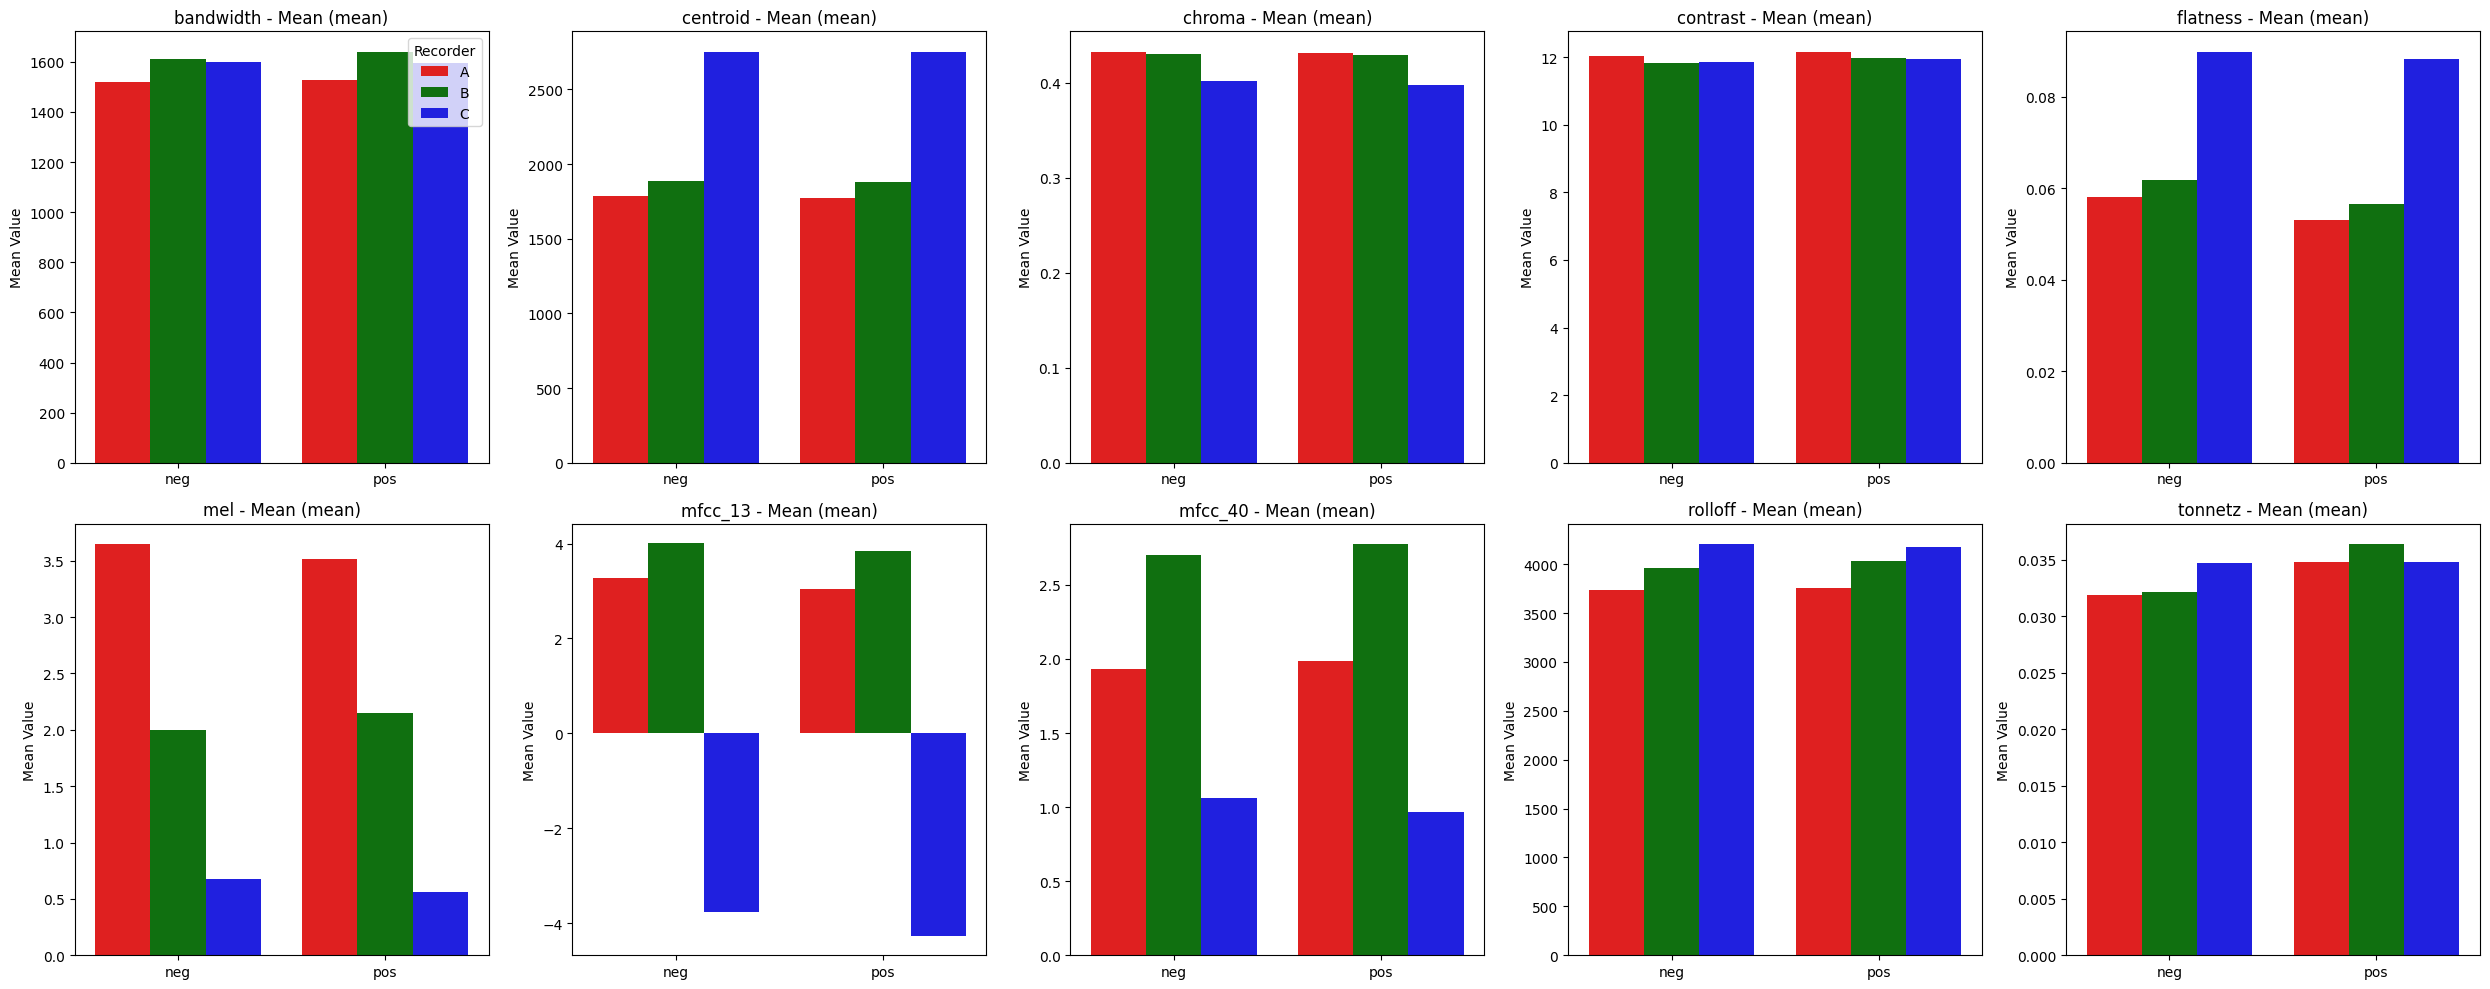

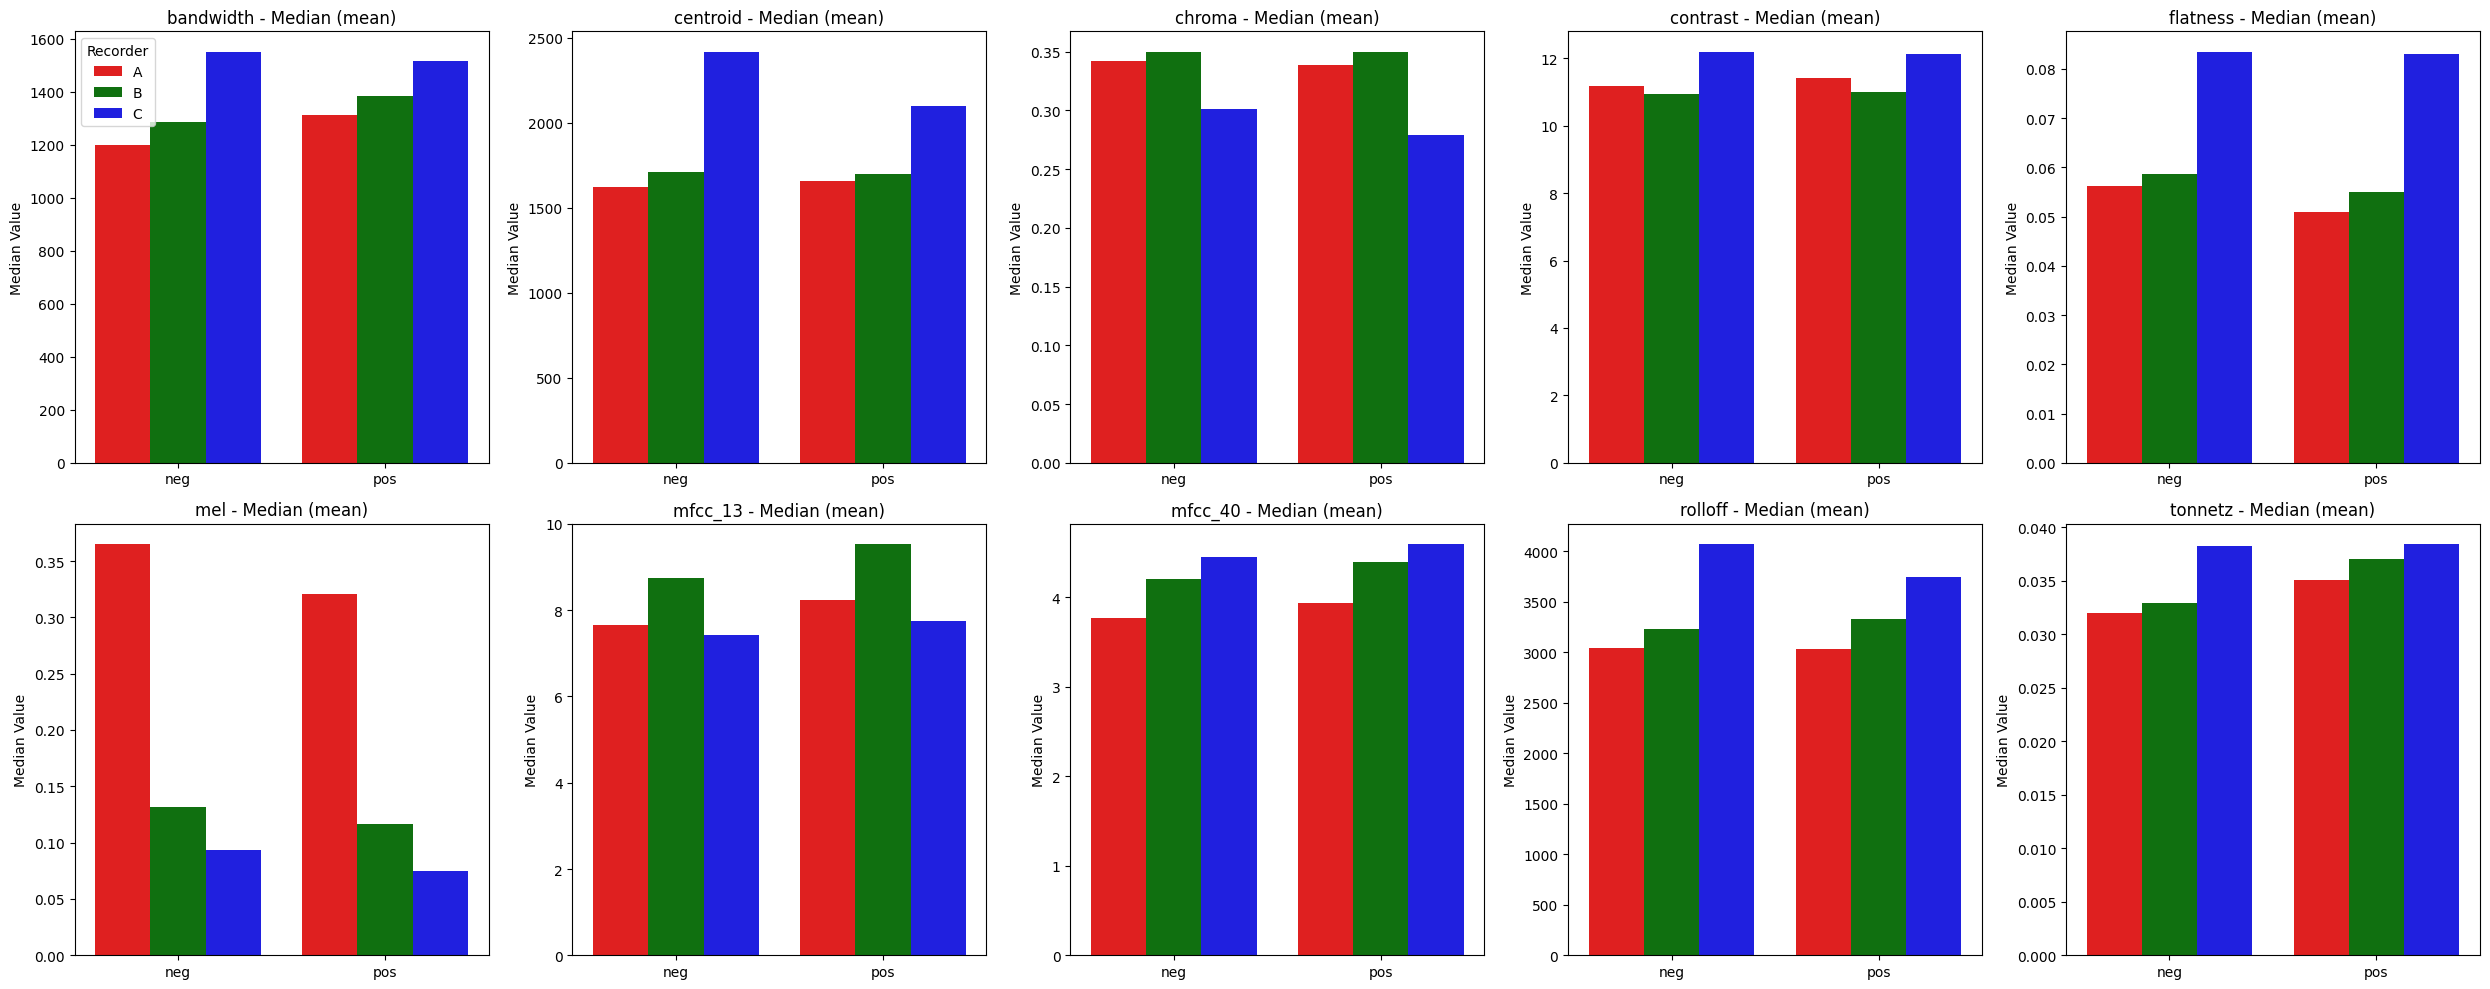

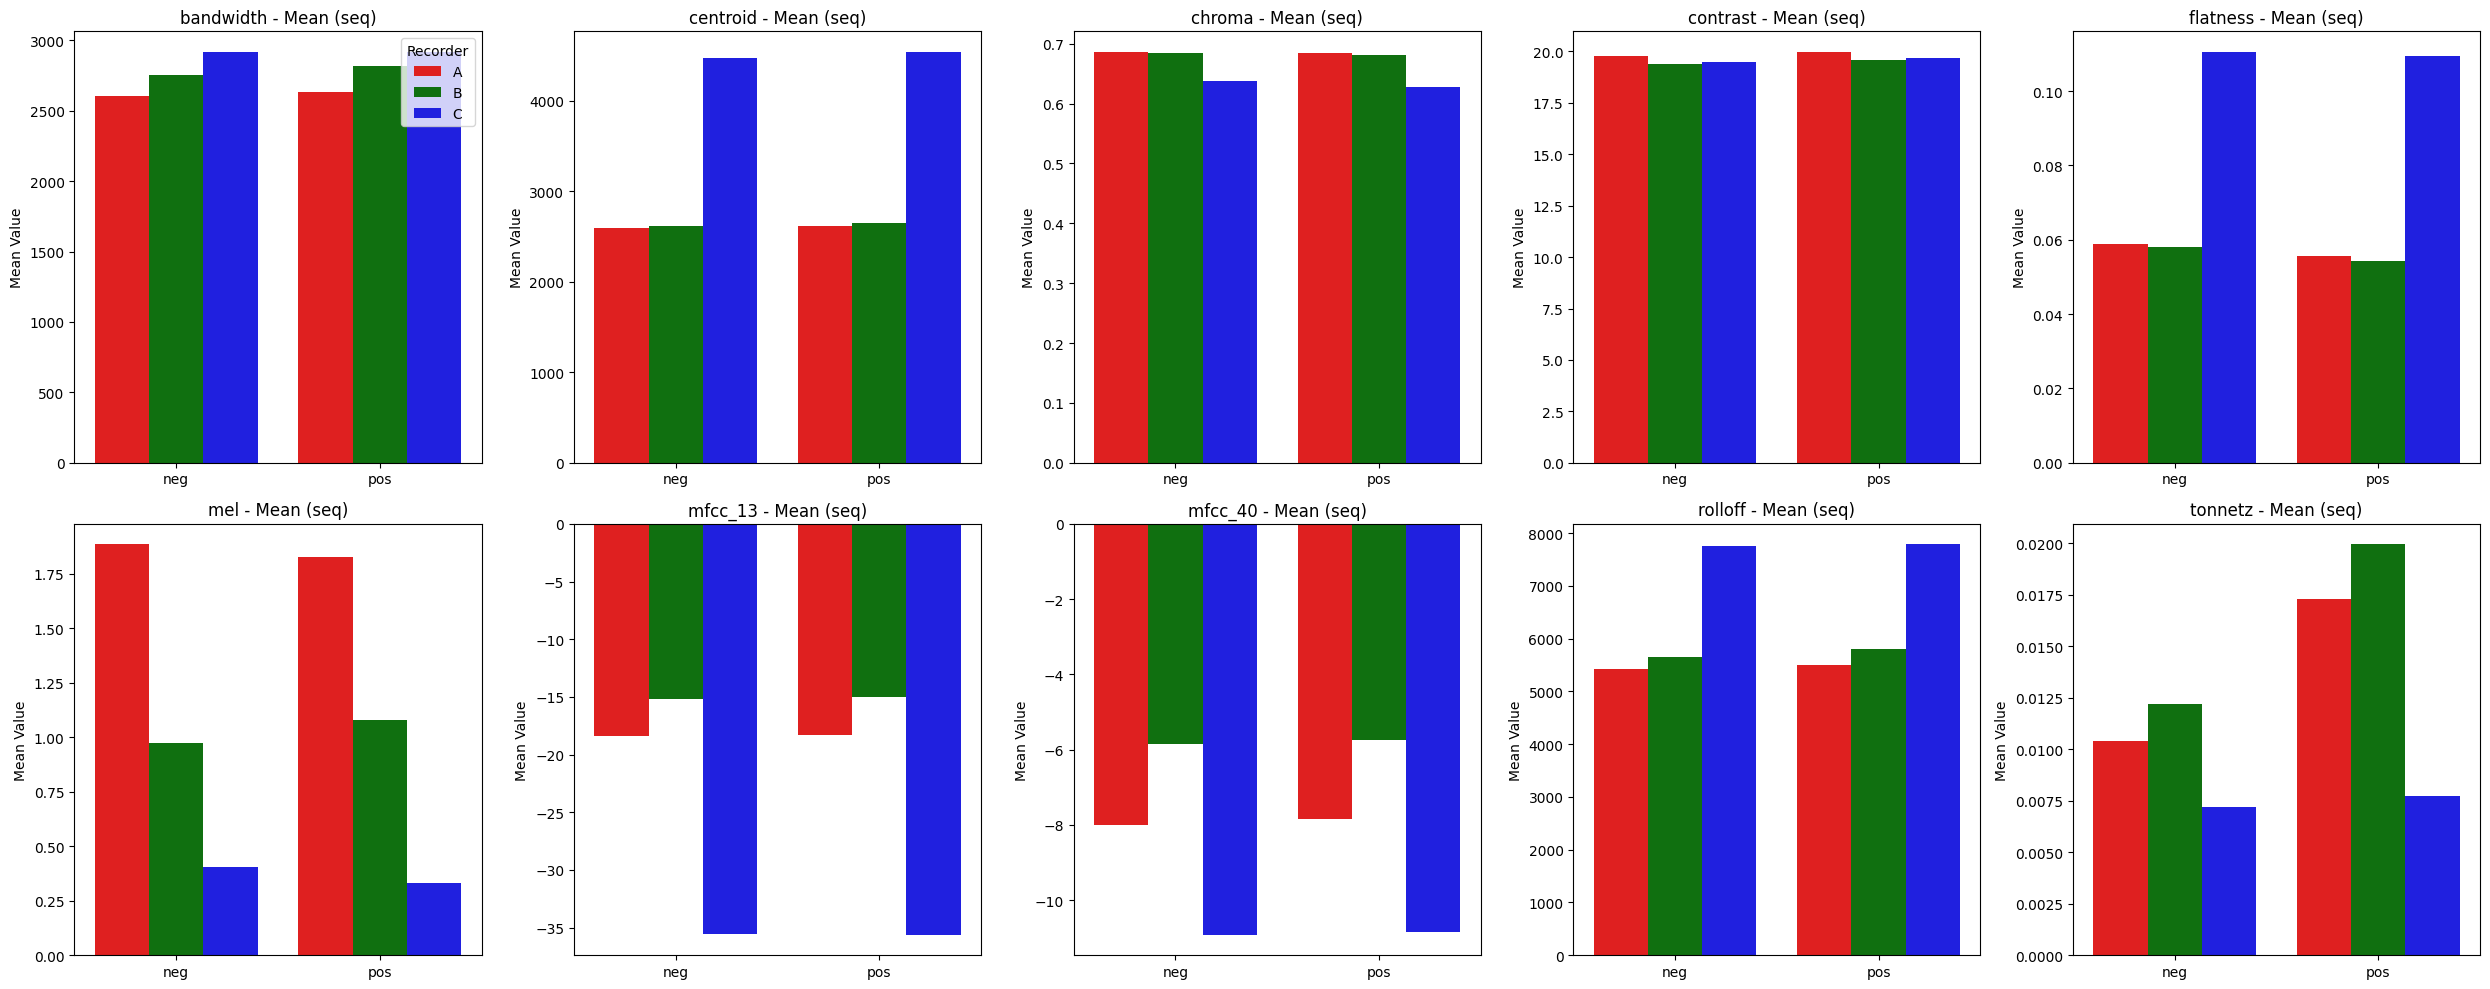

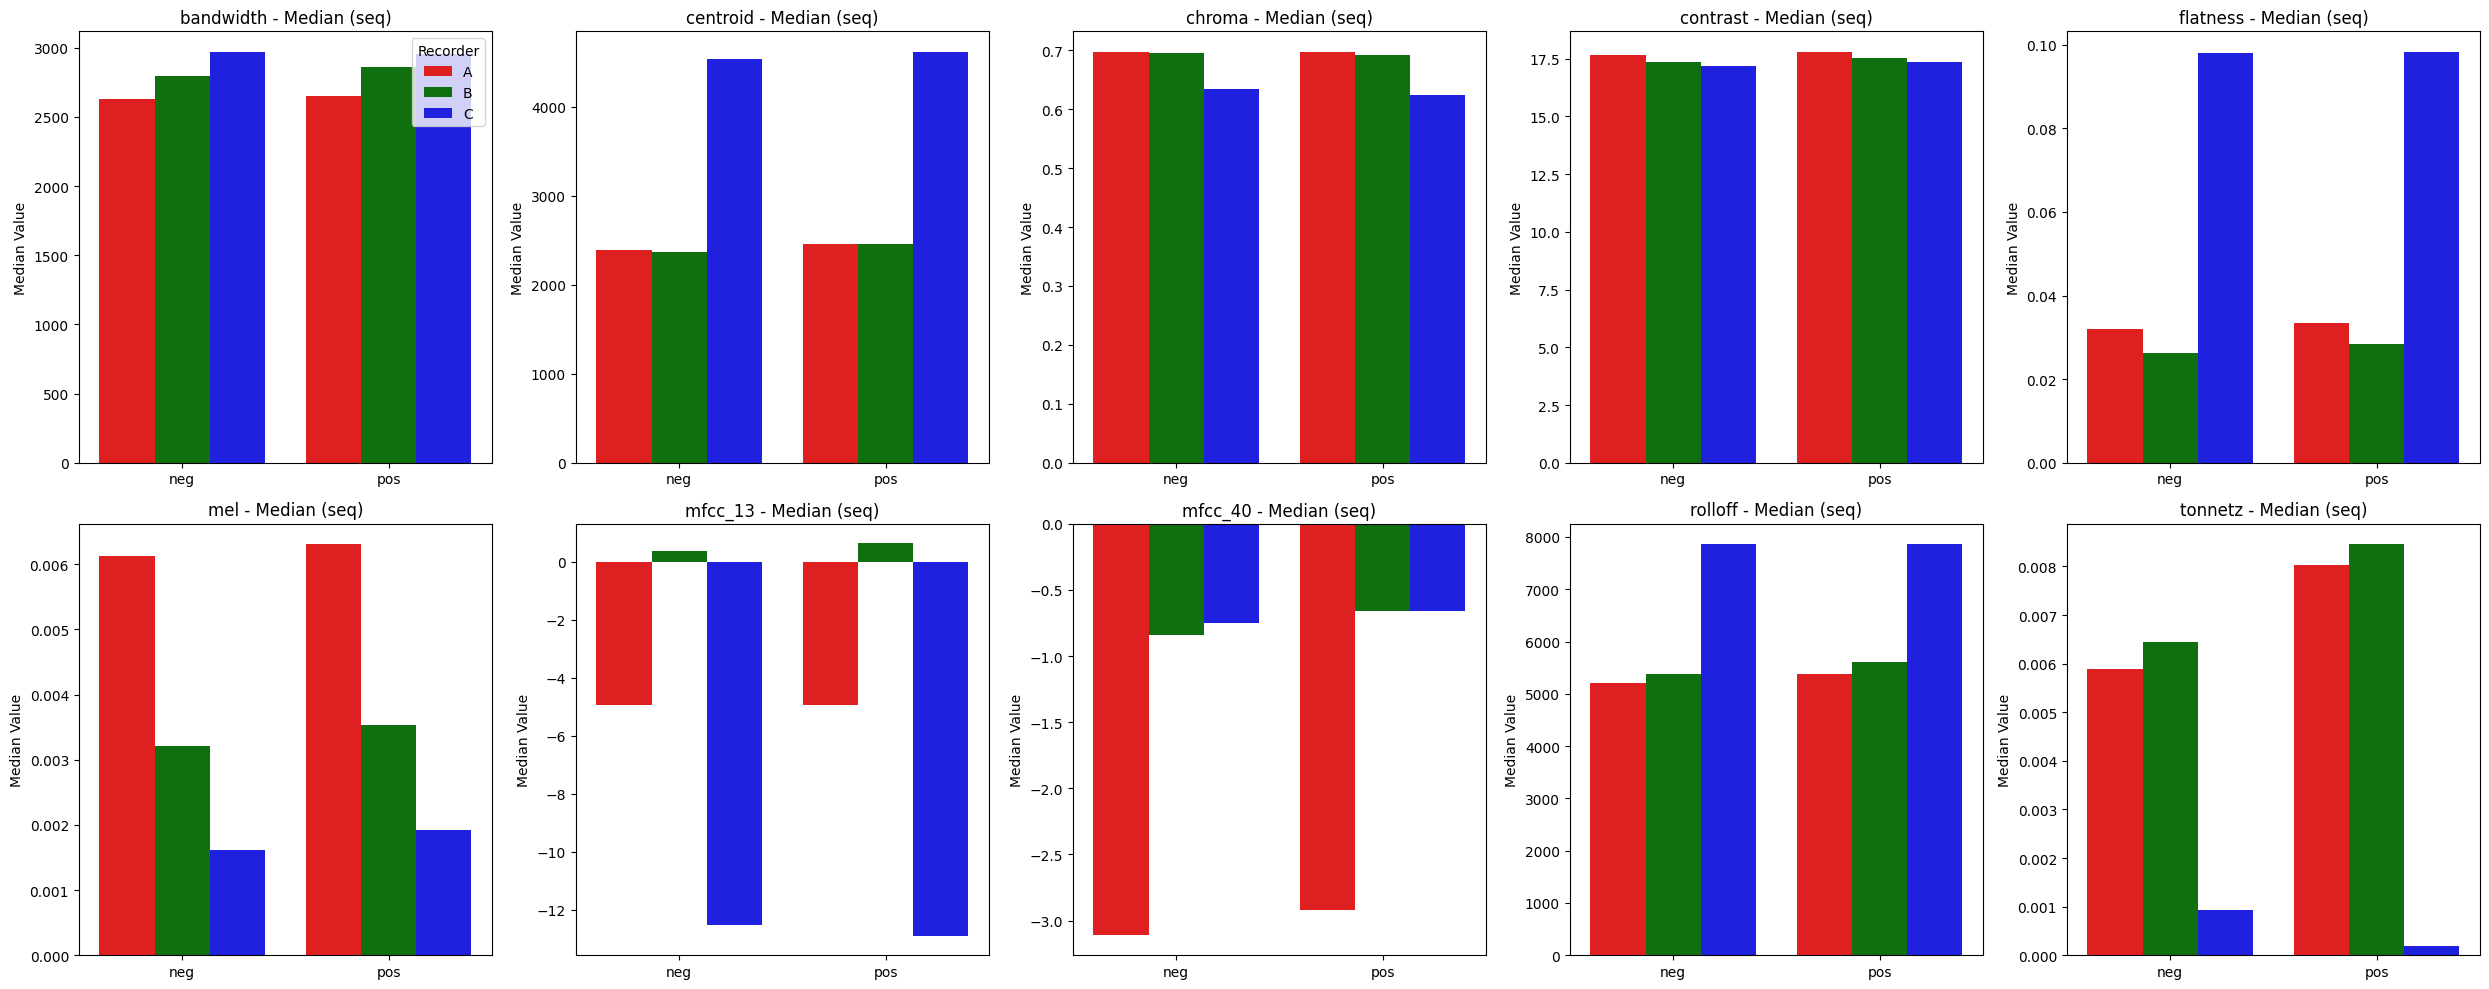

In [18]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import math

def visualize_summary(df_summary, version):
    if df_summary.empty:
        print(f"No data to visualize for {version}")
        return

    # Define recorder colors (A, B, C)
    recorder_palette = {
        "A": "red",
        "B": "green",
        "C": "blue"
    }

    # --- Preprocess Group -> Label + Recorder ---
    df = df_summary.copy()
    df["Recorder"] = df["Group"].str.extract(r"([ABC])")
    df["Label"] = df["Group"].str.extract(r"(pos|neg)")

    features = df["Feature"].unique()
    n_feats = len(features)

    # Split features into two halves
    half = math.ceil(n_feats / 2)
    feature_batches = [features[:half], features[half:]]

    # --- Per-feature Mean plots, batched into 2 rows ---
    fig, axes = plt.subplots(2, half, figsize=(5*half, 10))
    axes = axes.flatten()

    for idx, feat in enumerate(features):
        feat_df = df[df["Feature"] == feat]
        sns.barplot(
            data=feat_df,
            x="Label", y="Mean", hue="Recorder",
            palette=recorder_palette, errorbar=None,
            ax=axes[idx]
        )
        axes[idx].set_title(f"{feat} - Mean ({version})")
        axes[idx].set_ylabel("Mean Value")
        axes[idx].set_xlabel("")
        if idx == 0:
            axes[idx].legend(title="Recorder")
        else:
            axes[idx].get_legend().remove()

    # Hide empty subplots if any
    for ax in axes[n_feats:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Per-feature Median plots, batched into 2 rows ---
    fig, axes = plt.subplots(2, half, figsize=(5*half, 10))
    axes = axes.flatten()

    for idx, feat in enumerate(features):
        feat_df = df[df["Feature"] == feat]
        sns.barplot(
            data=feat_df,
            x="Label", y="Median", hue="Recorder",
            palette=recorder_palette, errorbar=None,
            ax=axes[idx]
        )
        axes[idx].set_title(f"{feat} - Median ({version})")
        axes[idx].set_ylabel("Median Value")
        axes[idx].set_xlabel("")
        if idx == 0:
            axes[idx].legend(title="Recorder")
        else:
            axes[idx].get_legend().remove()

    for ax in axes[n_feats:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# --- Step 4: Visualization ---
visualize_summary(df_summary_mean, "mean")
visualize_summary(df_summary_seq, "seq")


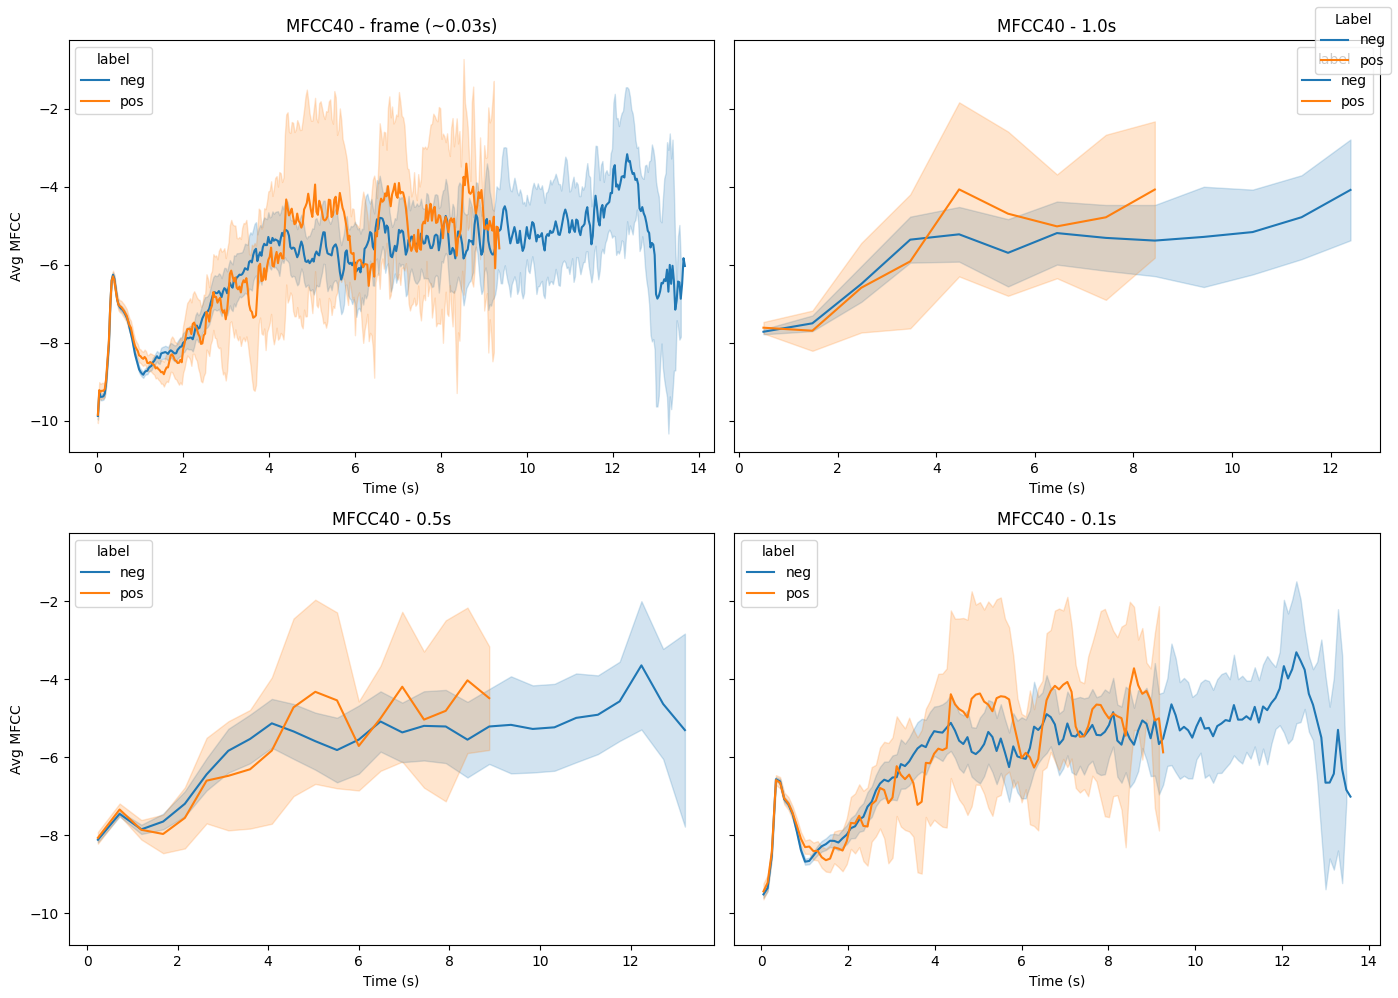

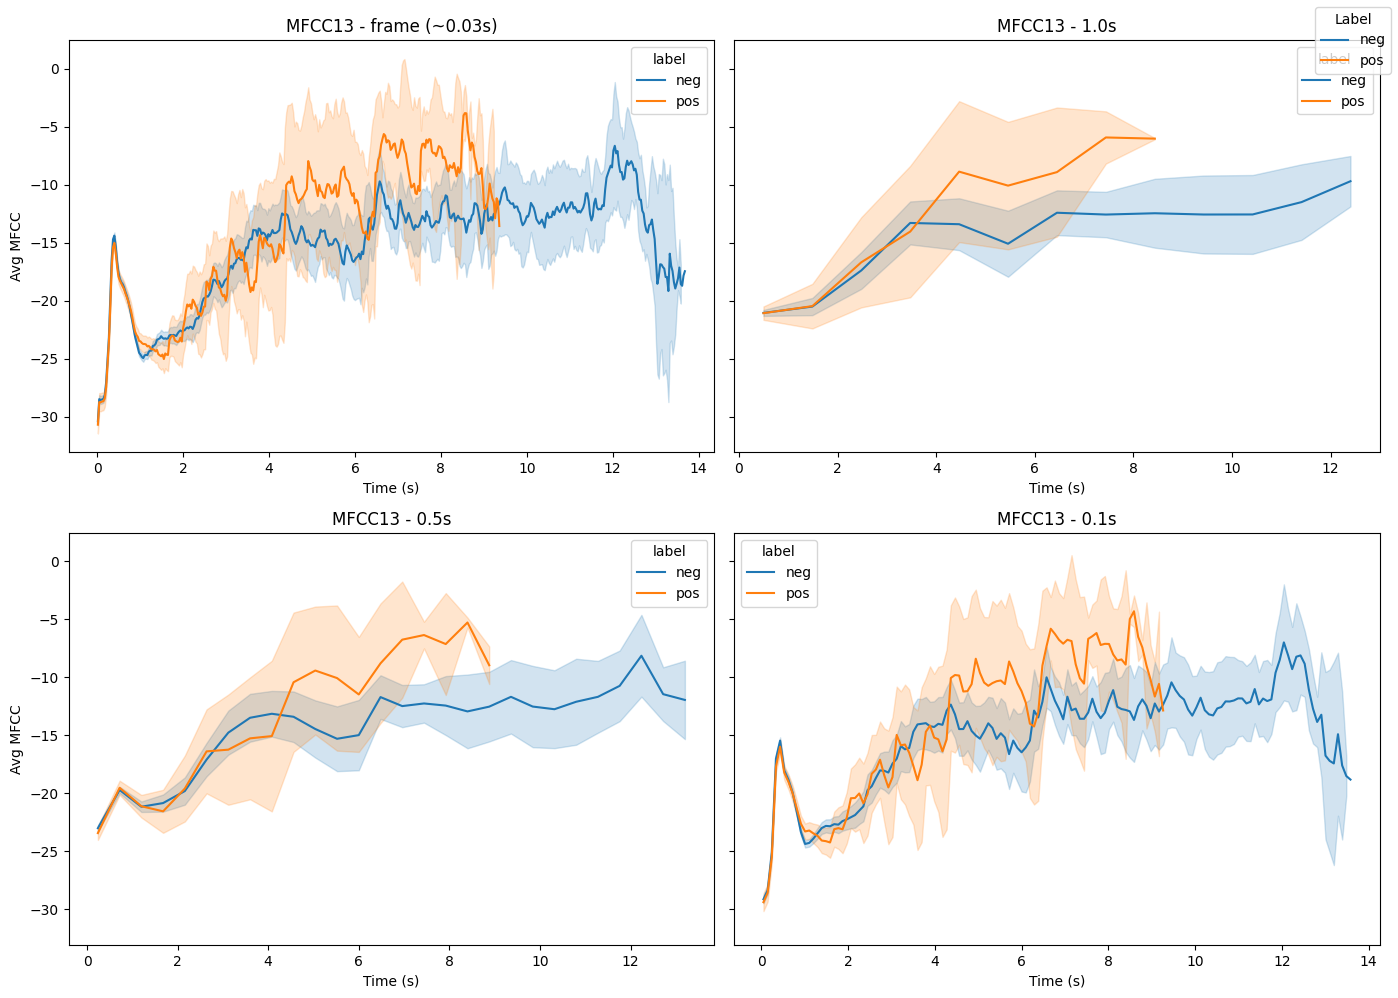

In [23]:
# Temporal MFCC averages at multiple resolutions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths ===
BASE_PATH = "./Dataset Google + CIDRZ Health AI Evaluation Zambia"
FEATURES_PATH_40 = os.path.join(BASE_PATH, "3_Fitur40")
OUTPUT_PATHS = {
    "mfcc40": os.path.join(BASE_PATH, "3_Fitur40", "seq"),
    "mfcc13": os.path.join(BASE_PATH, "3_Fitur13", "seq")
}

labels_map = {'pos': 1, 'neg': 0}

# --- Frame parameters (librosa defaults assumed) ---
SR = 16000        # sample rate
HOP = 512         # hop length
FRAME_DUR = HOP / SR   # seconds per frame (~0.032s)


def compute_avg_per_interval(X, y, interval_s=None):
    """
    Compute MFCC averages for each interval size.
    
    Args:
        X (ndarray): (n_samples, n_mfcc, n_frames)
        y (ndarray): labels
        interval_s (float|None): window size in seconds.
                                 None = per frame
    Returns:
        list of dicts {time, avg_mfcc, label}
    """
    results = []

    if interval_s is None:  # per frame
        win_size = 1
    else:
        win_size = int(interval_s / FRAME_DUR)

    for i in range(X.shape[0]):
        feat_array = X[i]
        # remove zero padding
        feat_array = feat_array[:, ~np.all(feat_array == 0, axis=0)]
        if feat_array.size == 0:
            continue

        n_frames = feat_array.shape[1]
        n_windows = n_frames // win_size if win_size > 1 else n_frames

        for w in range(n_windows):
            start = w * win_size
            end = start + win_size
            if interval_s is None:  # per frame
                seg = feat_array[:, start:start+1]
            else:
                seg = feat_array[:, start:end]
            if seg.size == 0:
                continue
            avg_val = np.mean(seg)
            time_mid = (start + seg.shape[1] / 2) * FRAME_DUR
            results.append({
                "time": time_mid,
                "avg_mfcc": avg_val,
                "label": "pos" if y[i] == labels_map["pos"] else "neg"
            })
    return results


def plot_mfcc_temporal(df, feature_name, interval_label):
    """Plot MFCC averages progression over time"""
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x="time",
        y="avg_mfcc",
        hue="label",
        errorbar=("se", 2)
    )
    plt.title(f"{feature_name.upper()} - Avg per {interval_label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Average MFCC")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()

def plot_mfcc_temporal_grid(results_dict, feature_name):
    """
    Plot MFCC averages at multiple intervals in a 2x2 grid.
    
    Args:
        results_dict: dict {interval_label: DataFrame}
        feature_name: 'mfcc13' or 'mfcc40'
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax, (interval_label, df) in zip(axes, results_dict.items()):
        sns.lineplot(
            data=df,
            x="time",
            y="avg_mfcc",
            hue="label",
            errorbar=("se", 2),
            ax=ax
        )
        ax.set_title(f"{feature_name.upper()} - {interval_label}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Avg MFCC")

    # Legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Label", loc="upper right")
    plt.tight_layout()
    plt.show()

# --- Main ---
if __name__ == "__main__":
    intervals = [
        (None, "frame (~0.03s)"),
        (1.0, "1.0s"),
        (0.5, "0.5s"),
        (0.1, "0.1s")
    ]

    for feat_key, base_path in OUTPUT_PATHS.items():
        try:
            X = np.load(os.path.join(base_path, "X_mfcc.npy"))
            y = np.load(os.path.join(base_path, "y.npy"))
        except FileNotFoundError:
            print(f"❌ Missing MFCC file in {base_path}, skipping...")
            continue

        results_dict = {}
        for interval_s, label in intervals:
            results = compute_avg_per_interval(X, y, interval_s)
            if not results:
                print(f"No data for {feat_key} at {label}")
                continue
            df = pd.DataFrame(results)
            results_dict[label] = df

        if results_dict:
            plot_mfcc_temporal_grid(results_dict, feat_key)